# **Libraries :**

In [ ]:
# Mounting and file handling
from google.colab import drive
import zipfile
import os

# Image and video processing
import cv2
import numpy as np

# Data preprocessing and manipulation
from sklearn.model_selection import train_test_split

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv3D, MaxPooling3D, Flatten, Dense, Dropout,
                                     Conv2D, MaxPooling2D, TimeDistributed, LSTM, Input)

# For Transformer (later)
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Layer, GlobalAveragePooling1D

# Optional: For evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# **Data Import :**

In [ ]:
from google.colab import drive
import zipfile
import os
import pandas as pd
import glob

In [ ]:
drive.mount('/content/drive')
zip_path = '/content/drive/MyDrive/Shop DataSet.zip'
extract_to = '/content/ShopDataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

Mounted at /content/drive


In [ ]:
import os
os.listdir('/content/ShopDataset')


['Shop DataSet']

In [ ]:
#Set Paths to Folders

shoplifters = os.path.join(extract_to, 'Shop DataSet', 'shop lifters')
nonshoplifters = os.path.join(extract_to, 'Shop DataSet', 'non shop lifters')

# **EDA – Exploratory Data Analysis :**

In [ ]:
print("Shoplifters videos:", len(os.listdir(shoplifters)))
print("Non-shoplifters videos:", len(os.listdir(nonshoplifters)))


Shoplifters videos: 324
Non-shoplifters videos: 531


# **Preprocessing NEW:**

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import albumentations as A

In [ ]:
# CREATE VIDEO DATAFRAME - THIS WAS MISSING FROM YOUR CODE
def create_video_dataframe():
    """Create DataFrame with video paths and labels"""
    video_paths = []
    labels = []

    # Get shoplifter videos (label = 1)
    shoplifter_files = glob.glob(os.path.join(shoplifters, '*.mp4'))
    if not shoplifter_files:  # Try other video formats if mp4 not found
        shoplifter_files = glob.glob(os.path.join(shoplifters, '*.avi'))
    if not shoplifter_files:
        shoplifter_files = glob.glob(os.path.join(shoplifters, '*.mov'))

    video_paths.extend(shoplifter_files)
    labels.extend([1] * len(shoplifter_files))

    # Get non-shoplifter videos (label = 0)
    non_shoplifter_files = glob.glob(os.path.join(nonshoplifters, '*.mp4'))
    if not non_shoplifter_files:  # Try other video formats if mp4 not found
        non_shoplifter_files = glob.glob(os.path.join(nonshoplifters, '*.avi'))
    if not non_shoplifter_files:
        non_shoplifter_files = glob.glob(os.path.join(nonshoplifters, '*.mov'))

    video_paths.extend(non_shoplifter_files)
    labels.extend([0] * len(non_shoplifter_files))

    video_df = pd.DataFrame({
        'filepath': video_paths,
        'label': labels
    })

    print(f"\nVideo DataFrame Created:")
    print(f"Total videos: {len(video_df)}")
    print(f"Shoplifters: {sum(video_df['label'] == 1)}")
    print(f"Non-shoplifters: {sum(video_df['label'] == 0)}")
    print(f"Sample paths:")
    print(video_df.head())

    return video_df

# Create the video dataframe
video_df = create_video_dataframe()


Video DataFrame Created:
Total videos: 855
Shoplifters: 324
Non-shoplifters: 531
Sample paths:
                                            filepath  label
0  /content/ShopDataset/Shop DataSet/shop lifters...      1
1  /content/ShopDataset/Shop DataSet/shop lifters...      1
2  /content/ShopDataset/Shop DataSet/shop lifters...      1
3  /content/ShopDataset/Shop DataSet/shop lifters...      1
4  /content/ShopDataset/Shop DataSet/shop lifters...      1


In [ ]:
# Extract Frames from Video Function
def video_to_frames(video_path, num_frames=16, resize=(112, 112)):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Warning: Could not open video {video_path}")
        return np.zeros((num_frames, resize[1], resize[0], 3), dtype=np.float32)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        print(f"Warning: Video {video_path} has 0 frames")
        cap.release()
        return np.zeros((num_frames, resize[1], resize[0], 3), dtype=np.float32)

    frame_indices = np.linspace(0, max(0, total_frames - 1), num_frames, dtype=int)

    frames = []
    idx = 0
    ret = True

    while ret and len(frames) < num_frames:
        ret, frame = cap.read()
        if idx in frame_indices:
            if frame is not None:
                frame = cv2.resize(frame, resize)
                frame = frame.astype(np.float32) / 255.0
                frames.append(frame)
        idx += 1

    cap.release()

    # Pad with zeros if not enough frames
    while len(frames) < num_frames:
        frames.append(np.zeros((resize[1], resize[0], 3), dtype=np.float32))

    return np.array(frames)



In [ ]:
# Train-Validation-Test Split
train_df, test_df = train_test_split(video_df, test_size=0.2, stratify=video_df['label'], random_state=42) # "stratify: Ensures that the ratios between classes (1 and 0) remain equal in each division.
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)

print(f"\nDataset Split:")
print(f"Train: {len(train_df)} videos")
print(f"  - Shoplifters: {sum(train_df['label'] == 1)}")
print(f"  - Non-shoplifters: {sum(train_df['label'] == 0)}")
print(f"Val: {len(val_df)} videos")
print(f"  - Shoplifters: {sum(val_df['label'] == 1)}")
print(f"  - Non-shoplifters: {sum(val_df['label'] == 0)}")
print(f"Test: {len(test_df)} videos")
print(f"  - Shoplifters: {sum(test_df['label'] == 1)}")
print(f"  - Non-shoplifters: {sum(test_df['label'] == 0)}")


Dataset Split:
Train: 615 videos
  - Shoplifters: 233
  - Non-shoplifters: 382
Val: 69 videos
  - Shoplifters: 26
  - Non-shoplifters: 43
Test: 171 videos
  - Shoplifters: 65
  - Non-shoplifters: 106


In [ ]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import albumentations as A
##################################
# CREATE VIDEO DATAFRAME - THIS WAS MISSING FROM YOUR CODE
def create_video_dataframe():
    """Create DataFrame with video paths and labels"""
    video_paths = []
    labels = []

    # Get shoplifter videos (label = 1)
    shoplifter_files = glob.glob(os.path.join(shoplifters, '*.mp4'))
    if not shoplifter_files:  # Try other video formats if mp4 not found
        shoplifter_files = glob.glob(os.path.join(shoplifters, '*.avi'))
    if not shoplifter_files:
        shoplifter_files = glob.glob(os.path.join(shoplifters, '*.mov'))

    video_paths.extend(shoplifter_files)
    labels.extend([1] * len(shoplifter_files))

    # Get non-shoplifter videos (label = 0)
    non_shoplifter_files = glob.glob(os.path.join(nonshoplifters, '*.mp4'))
    if not non_shoplifter_files:  # Try other video formats if mp4 not found
        non_shoplifter_files = glob.glob(os.path.join(nonshoplifters, '*.avi'))
    if not non_shoplifter_files:
        non_shoplifter_files = glob.glob(os.path.join(nonshoplifters, '*.mov'))

    video_paths.extend(non_shoplifter_files)
    labels.extend([0] * len(non_shoplifter_files))

    video_df = pd.DataFrame({
        'filepath': video_paths,
        'label': labels
    })

    print(f"\nVideo DataFrame Created:")
    print(f"Total videos: {len(video_df)}")
    print(f"Shoplifters: {sum(video_df['label'] == 1)}")
    print(f"Non-shoplifters: {sum(video_df['label'] == 0)}")
    print(f"Sample paths:")
    print(video_df.head())

    return video_df

# Create the video dataframe
video_df = create_video_dataframe()
###############################################
# Extract Frames from Video Function
def video_to_frames(video_path, num_frames=16, resize=(112, 112)):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Warning: Could not open video {video_path}")
        return np.zeros((num_frames, resize[1], resize[0], 3), dtype=np.float32)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames == 0:
        print(f"Warning: Video {video_path} has 0 frames")
        cap.release()
        return np.zeros((num_frames, resize[1], resize[0], 3), dtype=np.float32)

    frame_indices = np.linspace(0, max(0, total_frames - 1), num_frames, dtype=int)

    frames = []
    idx = 0
    ret = True

    while ret and len(frames) < num_frames:
        ret, frame = cap.read()
        if idx in frame_indices:
            if frame is not None:
                frame = cv2.resize(frame, resize)
                frame = frame.astype(np.float32) / 255.0
                frames.append(frame)
        idx += 1

    cap.release()

    # Pad with zeros if not enough frames
    while len(frames) < num_frames:
        frames.append(np.zeros((resize[1], resize[0], 3), dtype=np.float32))

    return np.array(frames)
########################################
# Train-Validation-Test Split
train_df, test_df = train_test_split(video_df, test_size=0.2, stratify=video_df['label'], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df['label'], random_state=42)

print(f"\nDataset Split:")
print(f"Train: {len(train_df)} videos")
print(f"  - Shoplifters: {sum(train_df['label'] == 1)}")
print(f"  - Non-shoplifters: {sum(train_df['label'] == 0)}")
print(f"Val: {len(val_df)} videos")
print(f"  - Shoplifters: {sum(val_df['label'] == 1)}")
print(f"  - Non-shoplifters: {sum(val_df['label'] == 0)}")
print(f"Test: {len(test_df)} videos")
print(f"  - Shoplifters: {sum(test_df['label'] == 1)}")
print(f"  - Non-shoplifters: {sum(test_df['label'] == 0)}")

In [ ]:
# Video Frame Generator Class
class VideoFrameGenerator(Sequence):
    def __init__(self, df, batch_size=4, num_frames=16, target_size=(112, 112), augment=False, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.num_frames = num_frames
        self.target_size = target_size
        self.augment = augment
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))

        if self.augment:
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
                A.Rotate(limit=10, p=0.3),
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
                A.Resize(height=target_size[0], width=target_size[1])
            ])
        else:
            self.transform = A.Compose([
                A.Resize(height=target_size[0], width=target_size[1])
            ])

        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_videos = []
        batch_labels = []

        for i in batch_indices:
            video_path = self.df.loc[i, 'filepath']
            label = self.df.loc[i, 'label']  # This is already 0 or 1

            try:
                frames = self.load_video_frames(video_path)
                batch_videos.append(frames)
                batch_labels.append(label)  # Keep as binary (0 or 1)
            except Exception as e:
                print(f"Error loading video {video_path}: {e}")
                # Create dummy frames if video fails to load
                dummy_frames = np.zeros((self.num_frames, self.target_size[0], self.target_size[1], 3))
                batch_videos.append(dummy_frames)
                batch_labels.append(label)

        # Return binary labels (not one-hot encoded)
        return np.array(batch_videos), np.array(batch_labels, dtype=np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def load_video_frames(self, path):
        cap = cv2.VideoCapture(path)

        if not cap.isOpened():
            raise Exception(f"Cannot open video: {path}")

        frames = []
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        if total_frames == 0:
            cap.release()
            raise Exception(f"Video has 0 frames: {path}")

        indices = np.linspace(0, max(0, total_frames - 1), self.num_frames).astype(int)

        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()

            if not ret or frame is None:
                frame = np.zeros((self.target_size[0], self.target_size[1], 3), dtype=np.uint8)
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = self.transform(image=frame)['image']

            frames.append(frame)

        cap.release()
        frames = np.stack(frames) / 255.0  # Normalize to [0, 1]
        return frames


In [ ]:
# Create Data Generators
print("Creating BINARY classification data generators...")
train_generator = VideoFrameGenerator(train_df, batch_size=4, augment=True)
val_generator = VideoFrameGenerator(val_df, batch_size=4, augment=False)
test_generator = VideoFrameGenerator(test_df, batch_size=4, augment=False)

print("Testing binary label format...")
X_batch, y_batch = next(iter(train_generator))
print(f"Video batch shape: {X_batch.shape}")
print(f"Label batch shape: {y_batch.shape}")
print(f"Label batch content: {y_batch}")
print(f"Label data type: {y_batch.dtype}")
print("✅ Binary labels are working correctly!")

Creating BINARY classification data generators...
Testing binary label format...


/tmp/ipython-input-2155966671.py:17: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


Video batch shape: (4, 16, 112, 112, 3)
Label batch shape: (4,)
Label batch content: [0. 0. 0. 1.]
Label data type: float32
✅ Binary labels are working correctly!



Testing data loading...
Successfully loaded batch with shape: (4, 16, 112, 112, 3)
Labels shape: (4,)


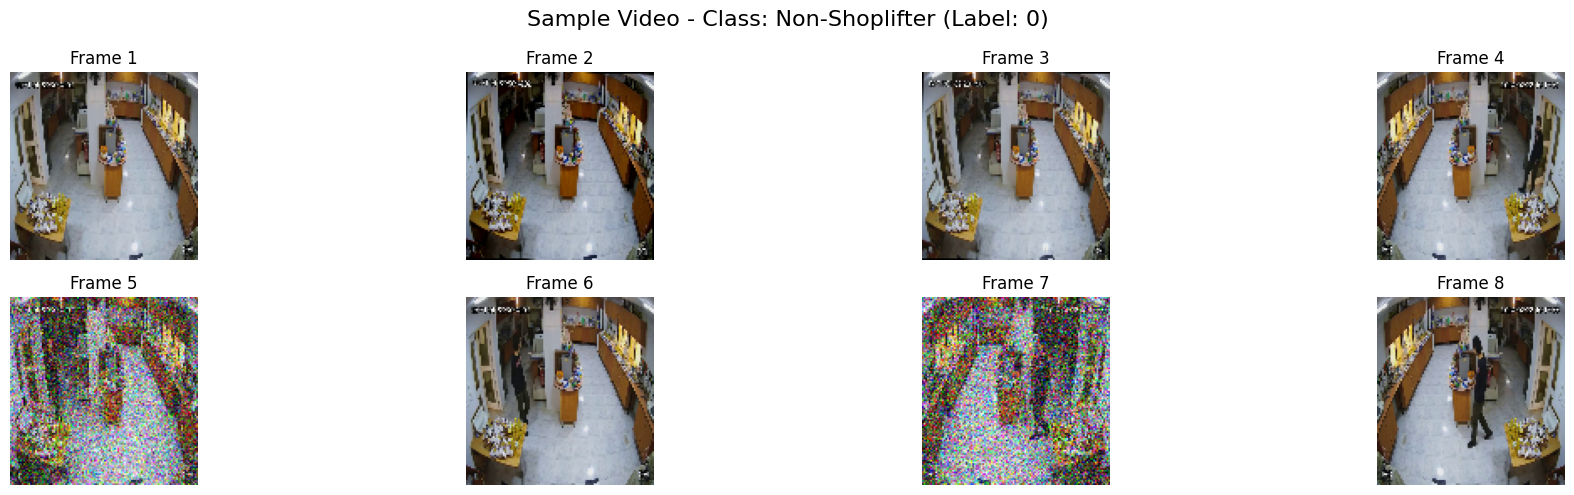

✅ Data preprocessing completed successfully!
✅ Data generators are ready for model training!


In [ ]:
# Test Data Loading and Show Example
print("\nTesting data loading...")
try:
    X_batch, y_batch = next(iter(train_generator))
    print(f"Successfully loaded batch with shape: {X_batch.shape}")
    print(f"Labels shape: {y_batch.shape}")

    # Show Example Frames
    video_idx = 0
    num_frames_to_show = min(8, X_batch.shape[1])  # Show 8 frames instead of 16 for better display

    plt.figure(figsize=(20, 5))
    for i in range(num_frames_to_show):
        frame = X_batch[video_idx][i]

        # Ensure frame is in correct format for display
        if frame.max() <= 1.0:
            frame = (frame * 255).astype('uint8')

        plt.subplot(2, 4, i + 1)
        plt.imshow(frame)  # Frame is already RGB from generator
        plt.axis('off')
        plt.title(f'Frame {i+1}')

    # Get label information
    label_idx = np.argmax(y_batch[video_idx])
    class_name = "Shoplifter" if label_idx == 1 else "Non-Shoplifter"

    plt.suptitle(f"Sample Video - Class: {class_name} (Label: {label_idx})", fontsize=16)
    plt.tight_layout()
    plt.show()

    print("✅ Data preprocessing completed successfully!")
    print("✅ Data generators are ready for model training!")

except Exception as e:
    print(f"❌ Error in data loading: {e}")
    print("Please check your video files and paths.")



In [ ]:
# Data Summary
print(f"\n{'='*50}")
print("PREPROCESSING SUMMARY")
print(f"{'='*50}")
print(f"✅ Dataset extracted and organized")
print(f"✅ Video DataFrame created with {len(video_df)} videos")
print(f"✅ Train/Val/Test split completed")
print(f"✅ Data generators created with augmentation")
print(f"✅ Sample data loading verified")
print(f"\nDataset is ready for 3D CNN model training!")
print(f"{'='*50}")

# Save the dataframes for later use (optional)
train_df.to_csv('train_videos.csv', index=False)
val_df.to_csv('val_videos.csv', index=False)
test_df.to_csv('test_videos.csv', index=False)
print("✅ Train/Val/Test splits saved as CSV files")


PREPROCESSING SUMMARY
✅ Dataset extracted and organized
✅ Video DataFrame created with 855 videos
✅ Train/Val/Test split completed
✅ Data generators created with augmentation
✅ Sample data loading verified

Dataset is ready for 3D CNN model training!
✅ Train/Val/Test splits saved as CSV files


# **Modeling :**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling3D
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# **3D CNN**

In [ ]:
# Import Required Libraries for Model
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv3D, MaxPooling3D, BatchNormalization, Dropout, GlobalAveragePooling3D, Dense, Input, Flatten)
from tensorflow.keras.callbacks import (ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# 3D CNN Model Architecture
def create_3d_cnn_model(input_shape=(16, 112, 112, 3), num_classes=1):
    """
    Create a 3D CNN model for BINARY video classification
    Args:
        input_shape: (frames, height, width, channels) - (16, 112, 112, 3)
        num_classes: 1 for binary classification (shoplifter vs non-shoplifter)
    """

    model = Sequential([
        # First 3D Convolutional Block
        Conv3D(32, (3, 3, 3), activation='relu', padding='same',
               input_shape=input_shape, name='conv3d_1'),
        BatchNormalization(name='bn_1'),
        Conv3D(32, (3, 3, 3), activation='relu', padding='same', name='conv3d_2'),
        MaxPooling3D((2, 2, 2), name='maxpool_1'),
        Dropout(0.25, name='dropout_1'),

        # Second 3D Convolutional Block
        Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv3d_3'),
        BatchNormalization(name='bn_2'),
        Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv3d_4'),
        MaxPooling3D((2, 2, 2), name='maxpool_2'),
        Dropout(0.25, name='dropout_2'),

        # Third 3D Convolutional Block
        Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv3d_5'),
        BatchNormalization(name='bn_3'),
        Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv3d_6'),
        MaxPooling3D((2, 2, 2), name='maxpool_3'),
        Dropout(0.3, name='dropout_3'),

        # Fourth 3D Convolutional Block
        Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3d_7'),
        BatchNormalization(name='bn_4'),
        MaxPooling3D((2, 2, 2), name='maxpool_4'),
        Dropout(0.3, name='dropout_4'),

        # Global Average Pooling and Dense layers
        GlobalAveragePooling3D(name='global_avg_pool'),
        Dense(512, activation='relu', kernel_regularizer=l2(0.01), name='dense_1'),
        BatchNormalization(name='bn_5'),
        Dropout(0.5, name='dropout_5'),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01), name='dense_2'),
        BatchNormalization(name='bn_6'),
        Dropout(0.5, name='dropout_6'),
        Dense(num_classes, activation='sigmoid', name='output')  # sigmoid for binary classification
    ])

    return model


In [ ]:
# Create and Compile the Model
print("Creating 3D CNN model...")
model = create_3d_cnn_model(input_shape=(16, 112, 112, 3), num_classes=1)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Display model architecture
print("\nModel Architecture:")
model.summary()

# Calculate total parameters
total_params = model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")

In [ ]:
# Define Callbacks for Training
callbacks = [
    # Model checkpoint - save best model based on validation accuracy
    ModelCheckpoint(
        'best_shoplifting_3d_cnn_binary.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1,
        save_freq='epoch'
    ),

    # Early stopping to prevent overfitting
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1,
        mode='min'
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),

    # Log training metrics to CSV
    CSVLogger('training_history_binary.csv', append=False, separator=',')
]


In [ ]:

# Model Training
print(f"\n{'='*50}")
print("STARTING MODEL TRAINING")
print(f"{'='*50}")
print(f"Training for {EPOCHS} epochs with batch size {BATCH_SIZE}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Steps per epoch: {len(train_generator)}")
print(f"Validation steps: {len(val_generator)}")



In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1,
    use_multiprocessing=False,  # Set to False to avoid potential issues in Colab
    workers=1
)


In [ ]:
# Plot Training History
print("\n Plotting training history...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training & Validation Accuracy
axes[0, 0].plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Training & Validation Loss
axes[0, 1].plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
axes[0, 1].set_title('Model Loss Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], 'g-', label='Training Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], 'orange', label='Validation Precision', linewidth=2)
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], 'm-', label='Training Recall', linewidth=2)
axes[1, 1].plot(history.history['val_recall'], 'cyan', label='Validation Recall', linewidth=2)
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#####################################################
# Model Evaluation on Test Set
print(f"\n{'='*50}")
print("MODEL EVALUATION ON TEST SET - BINARY CLASSIFICATION")
print(f"{'='*50}")

# Evaluate model
test_results = model.evaluate(test_generator, verbose=1)
test_loss = test_results[0]
test_accuracy = test_results[1]
test_precision = test_results[2] if len(test_results) > 2 else None
test_recall = test_results[3] if len(test_results) > 3 else None

print(f"\n Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Accuracy Percentage: {test_accuracy*100:.2f}%")
if test_precision:
    print(f"Test Precision: {test_precision:.4f}")
if test_recall:
    print(f"Test Recall: {test_recall:.4f}")

# Get detailed predictions
print("\n Getting detailed predictions...")
predictions = model.predict(test_generator, verbose=1)
y_pred = (predictions > 0.5).astype(int).flatten()

# Get true labels
y_true = []
test_generator_copy = VideoFrameGenerator(test_df, batch_size=4, augment=False, shuffle=False)

for i in range(len(test_generator_copy)):
    _, labels = test_generator_copy[i]
    y_true.extend(labels.flatten())

# Ensure same length
min_len = min(len(y_true), len(y_pred))
y_true = np.array(y_true[:min_len])
y_pred = y_pred[:min_len]

# Classification report
class_names = ['Non-Shoplifter', 'Shoplifter']
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(f"\n📋 Detailed Classification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Binary Classification Results', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add accuracy text
accuracy_text = f'Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)'
plt.figtext(0.5, 0.02, accuracy_text, ha='center', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))

plt.tight_layout()
plt.show()

In [ ]:
# Single Video Prediction
print(f"\n Single Video Prediction Function:")
print("To predict on a single video, use:")
print("predictions = model.predict(video_frames)")
print("prob_shoplifter = predictions[0][0]")
print("predicted_class = 1 if prob_shoplifter > 0.5 else 0")

# Example prediction on test video
if len(test_df) > 0:
    sample_video_path = test_df.iloc[0]['filepath']
    print(f"\n Testing on sample video: {sample_video_path}")

    try:
        # Load and preprocess video
        frames = video_to_frames(sample_video_path, num_frames=16, resize=(112, 112))
        frames = np.expand_dims(frames, axis=0)

        # Get prediction
        prediction = model.predict(frames, verbose=0)
        prob_shoplifter = prediction[0][0]
        predicted_class = 1 if prob_shoplifter > 0.5 else 0
        class_name = "Shoplifter" if predicted_class == 1 else "Non-Shoplifter"

        print(f"Prediction: {class_name}")
        print(f"Shoplifter Probability: {prob_shoplifter:.4f} ({prob_shoplifter*100:.2f}%)")

        if predicted_class == 1:
            print("ALERT: Potential shoplifting behavior detected!")
        else:
            print(" Normal behavior detected")

    except Exception as e:
        print(f" Error processing video: {e}")


# **CNN + RNN**

In [ ]:
# Import Required Libraries for Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, LSTM, TimeDistributed, Input, GlobalAveragePooling1D
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten,
    LSTM, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def create_cnn_lstm_model(input_shape=(6, 112, 112, 3), num_classes=1):
    """
    CNN + LSTM model from scratch for binary video classification.
    input_shape: (frames, height, width, channels)
    """
    frames, height, width, channels = input_shape

    input_layer = Input(shape=input_shape)

    # TimeDistributed CNN layers
    x = TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'))(input_layer)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D((2, 2)))(x)
    x = TimeDistributed(Flatten())(x)

    # LSTM
    x = LSTM(128, return_sequences=False)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)  # ✅ FIXED: applied correctly to previous layer
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    output = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)
    return model


In [ ]:
print("Creating CNN+LSTM model...")
model = create_cnn_lstm_model(input_shape=(16, 112, 112, 3), num_classes=1)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Show model architecture
print("\nModel Architecture:")
model.summary()

# Total trainable parameters
total_params = model.count_params()
print(f"\nTotal trainable parameters: {total_params:,}")


Creating CNN+LSTM model...


I0000 00:00:1754728460.467133      76 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16, 112, 112,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 16, 112, 112,   │           896 │
│ (TimeDistributed)               │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 16, 56, 56, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 16, 56, 56, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 28, 28, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 16, 50176)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │    25,756,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,801,153 (98.42 MB)

 Trainable params: 25,800,769 (98.42 MB)

 Non-trainable params: 384 (1.50 KB)


Total trainable parameters: 25,801,153


In [ ]:
# Define Callbacks for Training
callbacks = [
    # Model checkpoint - save best model based on validation accuracy
    ModelCheckpoint(
        'best_shoplifting_3d_cnn_binary.h5',
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        verbose=1,
        save_freq='epoch'
    ),

    # Early stopping to prevent overfitting
     EarlyStopping(
         monitor='val_loss',
         patience=10,
         restore_best_weights=True,
         verbose=1,
         mode='min'
     ),


    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1,
        mode='min'
    ),

    # Log training metrics to CSV
    CSVLogger('training_history_binary.csv', append=False, separator=',')
]


In [ ]:
# Training Configuration
EPOCHS = 70
BATCH_SIZE = 2

# Verify data generators are working
print("\nVerifying data generators...")
print(f"Train generator batches: {len(train_generator)}")
print(f"Validation generator batches: {len(val_generator)}")
print(f"Test generator batches: {len(test_generator)}")

# Test a batch to ensure everything works
try:
    sample_batch, sample_labels = next(iter(train_generator))
    print(f"Sample batch shape: {sample_batch.shape}")
    print(f"Sample labels shape: {sample_labels.shape}")
    print(f"Sample labels: {sample_labels}")
    print("✅ Data generators are working correctly!")
except Exception as e:
    print(f"❌ Error with data generators: {e}")


Verifying data generators...
Train generator batches: 154
Validation generator batches: 18
Test generator batches: 43
Sample batch shape: (4, 16, 112, 112, 3)
Sample labels shape: (4,)
Sample labels: [0. 0. 0. 0.]
✅ Data generators are working correctly!


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training completed!")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/70


I0000 00:00:1754728481.131954     162 cuda_dnn.cc:529] Loaded cuDNN version 90300


154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5165 - loss: 2.5576
Epoch 1: val_accuracy improved from -inf to 0.62319, saving model to best_shoplifting_3d_cnn_binary.h5
154/154 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.5167 - loss: 2.5549 - val_accuracy: 0.6232 - val_loss: 1.6627 - learning_rate: 0.0010
Epoch 2/70
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6501 - loss: 1.5885
Epoch 2: val_accuracy did not improve from 0.62319
154/154 ━━━━━━━━━━━━━━━━━━━━ 392s 3s/step - accuracy: 0.6499 - loss: 1.5881 - val_accuracy: 0.6232 - val_loss: 1.3842 - learning_rate: 0.0010
Epoch 3/70
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6196 - loss: 1.3463
Epoch 3: val_accuracy did not improve from 0.62319
154/154 ━━━━━━━━━━━━━━━━━━━━ 390s 3s/step - accuracy: 0.6195 - loss: 1.3461 - val_accuracy: 0.6232 - val_loss: 1.3350 - learning_rate: 0.0010
Epoch 4/70
154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6376 - loss: 1.1808
Epoch 4: val_accuracy did not improve fr

In [ ]:
def plot_training_history(history, f1_scores=None):
    plt.figure(figsize=(18, 5))

    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot F1 Score (if provided)
    if f1_scores is not None:
        plt.subplot(1, 3, 3)
        plt.plot(f1_scores, label='Val F1 Score', color='purple')
        plt.title("F1 Score Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("F1 Score")
        plt.legend()

    plt.tight_layout()
    plt.show()


In [ ]:
plot_training_history(history, f1_scores=f1_callback.f1_scores)


NameError: name 'history' is not defined